Epoch 1:  66%|██████▌   | 559/851 [09:48<04:07,  1.18it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10: 100%|██████████| 851/851 [07:13<00:00,  1.96it/s]


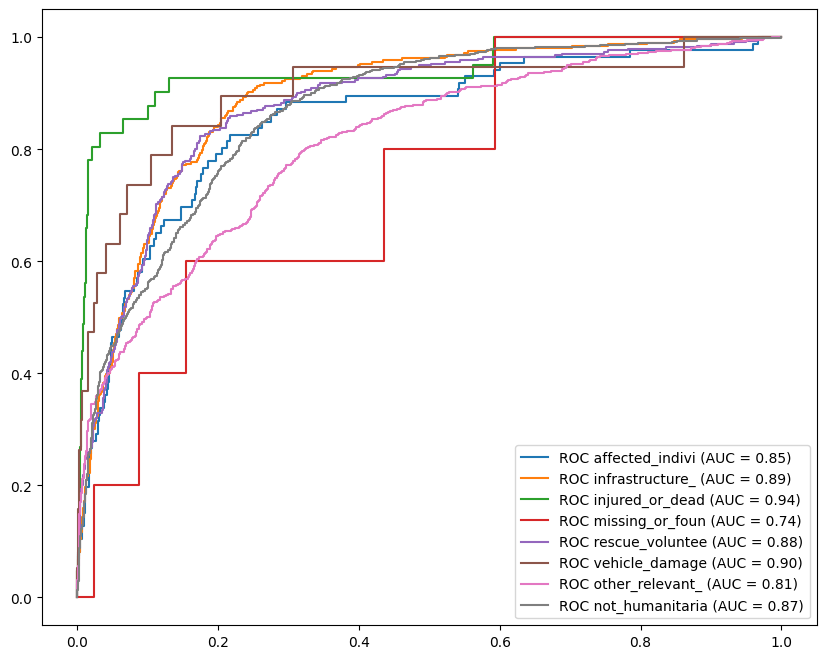

                                        precision    recall  f1-score   support

                  affected_individuals       0.27      0.34      0.30        86
     infrastructure_and_utility_damage       0.47      0.68      0.56       319
                injured_or_dead_people       0.45      0.66      0.53        41
               missing_or_found_people       0.00      0.00      0.00         5
rescue_volunteering_or_donation_effort       0.55      0.49      0.52       340
                        vehicle_damage       0.38      0.16      0.22        19
            other_relevant_information       0.60      0.51      0.55       578
                      not_humanitarian       0.72      0.68      0.70       849

                              accuracy                           0.59      2237
                             macro avg       0.43      0.44      0.42      2237
                          weighted avg       0.60      0.59      0.59      2237



d:\Anaconda\envs\tweet_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Anaconda\envs\tweet_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Anaconda\envs\tweet_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from transformers import CLIPModel, CLIPProcessor, get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

# --- 1. DATASET LOADER: HUMANITARIAN SYNC ---
class CrisisHumanitarianDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        # Exact mapping for humanitarian categories
        self.label_map = {
            "affected_individuals": 0, "infrastructure_and_utility_damage": 1,
            "injured_or_dead_people": 2, "missing_or_found_people": 3,
            "rescue_volunteering_or_donation_effort": 4, "vehicle_damage": 5,
            "other_relevant_information": 6, "not_humanitarian": 7
        }

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        rel_path = str(row['image']).replace('\\', '/').lstrip('/')
        img_path = os.path.normpath(os.path.join(self.img_dir, rel_path))
        
        if not os.path.exists(img_path): return None
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long),
                'img_path': img_path
            }
        except Exception: return None

def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

# --- 2. ARCHITECTURE: SYMMETRIC DUAL-PATH FUSION ---
class SymmetricFusion(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.gamma = nn.Parameter(0.5 * torch.ones(embed_dim * 2))
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, 512), nn.GELU(), nn.Linear(512, embed_dim * 2), nn.Sigmoid())
        self.norm = nn.LayerNorm(embed_dim * 2)

    def forward(self, t_f, i_f):
        # Bi-directional attention handshake
        a_t = F.scaled_dot_product_attention(t_f.unsqueeze(1), i_f.unsqueeze(1), i_f.unsqueeze(1)).squeeze(1)
        a_i = F.scaled_dot_product_attention(i_f.unsqueeze(1), t_f.unsqueeze(1), t_f.unsqueeze(1)).squeeze(1)
        combined = torch.cat((a_t, a_i), dim=1)
        return self.norm(torch.cat((t_f, i_f), dim=1) + (self.gamma * (combined * self.gate(combined))))



class HumanitarianVLM(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # ADD use_safetensors=True HERE
        self.clip = CLIPModel.from_pretrained(
            "openai/clip-vit-base-patch32", 
            use_safetensors=True
        )
        self.fusion = SymmetricFusion()
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512), 
            nn.GELU(),
            nn.Dropout(0.5), 
            nn.Linear(512, num_classes)
        )

    def forward(self, ids, mask, pix):
        t_f = self.clip.get_text_features(input_ids=ids, attention_mask=mask)
        i_f = self.clip.get_image_features(pixel_values=pix)
        t_f, i_f = F.normalize(t_f, p=2, dim=-1), F.normalize(i_f, p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

# --- 3. TRAINING & EVALUATION SETUP ---
device = torch.device("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

IMG_ROOT = r"F:\research\chatbot\D\Multi-modal-codes" 
# Use 'r' before the string to treat backslashes as literal text
TRAIN_TSV = os.path.join(IMG_ROOT, r"data\CrisisMMD\crisismmd_datasplit_all\crisismmd_datasplit_all\task_humanitarian_text_img_train.tsv")
TEST_TSV  = os.path.join(IMG_ROOT, r"data\CrisisMMD\crisismmd_datasplit_all\crisismmd_datasplit_all\task_humanitarian_text_img_test.tsv")

# Alternative (even safer): Use forward slashes which work on both Windows and Linux
# TRAIN_TSV = os.path.join(IMG_ROOT, "data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_humanitarian_text_img_train.tsv")

train_loader = DataLoader(CrisisHumanitarianDataset(TRAIN_TSV, IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
test_loader = DataLoader(CrisisHumanitarianDataset(TEST_TSV, IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

model = HumanitarianVLM().to(device)
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

# Class-weighted loss for imbalanced humanitarian data
weights = torch.tensor([1.5, 1.2, 2.0, 2.5, 1.0, 1.5, 0.8, 0.8]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.25)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scaler = GradScaler('cuda')

# --- 4. EXECUTION LOOP ---
for epoch in range(10):
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

# --- 5. FINAL ANALYTICS (Q1 JOURNAL STANDARDS) ---
model.eval()
y_true, y_pred, y_probs = [], [], []
label_names = list(train_loader.dataset.label_map.keys())

with torch.no_grad():
    for b in test_loader:
        logits = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
        y_probs.extend(torch.softmax(logits, dim=1).cpu().numpy())
        y_true.extend(b['label'].numpy())
        y_pred.extend(torch.argmax(logits, 1).cpu().numpy())

# ROC Curve Generation
y_true_bin = label_binarize(y_true, classes=range(8))
plt.figure(figsize=(10, 8))
for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_probs)[:, i])
    plt.plot(fpr, tpr, label=f'ROC {label_names[i][:15]} (AUC = {auc(fpr, tpr):.2f})')
plt.legend(); plt.show()

# Final Report
print(classification_report(y_true, y_pred, target_names=label_names))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, f1_score)
from sklearn.preprocessing import label_binarize
from transformers import CLIPModel, CLIPProcessor, get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

class CrisisHumanitarianDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        
        # DEFINED LABELS (Mapped for 5 Unique Semantic Classes)
        self.label_map = {
            "infrastructure_and_utility_damage": 0,
            "other_relevant_information": 1,
            "not_humanitarian": 2,
            "rescue_volunteering_or_donation_effort": 3,
            "affected_individuals": 4
        }
        
        # Filter data to only include these labels to prevent KeyErrors
        self.data = self.data[self.data['label'].isin(self.label_map.keys())].reset_index(drop=True)

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        rel_path = str(row['image']).replace('\\', '/').lstrip('/')
        img_path = os.path.normpath(os.path.join(self.img_dir, rel_path))
        
        if not os.path.exists(img_path): return None
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long),
                'img_path': img_path
            }
        except Exception: return None
        
def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

# --- LOADER INITIALIZATION ---
IMG_ROOT  = r"F:\research\chatbot\D\Multi-modal-codes" 
DATA_PATH = r"data\CrisisMMD\crisismmd_datasplit_all\crisismmd_datasplit_agreed_label"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

train_loader = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_PATH, "task_humanitarian_text_img_agreed_lab_train.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
dev_loader   = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_PATH, "task_humanitarian_text_img_agreed_lab_dev.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)
test_loader  = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_PATH, "task_informative_text_img_agreed_lab_test.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

In [11]:
class GatedHumanitarianFusion(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.text_proj = nn.Linear(embed_dim, 512)
        self.image_proj = nn.Linear(embed_dim, 512)
        self.gate = nn.Sequential(
            nn.Linear(embed_dim * 2, 256),
            nn.GELU(),
            nn.Linear(256, 2),
            nn.Softmax(dim=1)
        )
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, t_f, i_f):
        t_p, i_p = F.gelu(self.text_proj(t_f)), F.gelu(self.image_proj(i_f))
        weights = self.gate(torch.cat([t_f, i_f], dim=1))
        # Gating allows the model to prioritize text for "Rescue" and image for "Damage"
        fused = (weights[:, 0:1] * t_p) + (weights[:, 1:2] * i_p)
        return self.layer_norm(fused)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha, self.gamma = alpha, gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1 - pt)**self.gamma * ce_loss).mean()

class AdvancedHumanitarianVLM(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)
        self.fusion = GatedHumanitarianFusion()
        self.classifier = nn.Sequential(
            nn.Linear(512, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(0.4), nn.Linear(512, num_classes)
        )

    def forward(self, ids, mask, pix):
        t_f = self.clip.get_text_features(input_ids=ids, attention_mask=mask)
        i_f = self.clip.get_image_features(pixel_values=pix)
        t_f, i_f = F.normalize(t_f, p=2, dim=-1), F.normalize(i_f, p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

In [12]:
device = torch.device("cuda")
model = AdvancedHumanitarianVLM().to(device)
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

optimizer = optim.AdamW([
    {'params': model.base_model.clip.parameters(), 'lr': 1e-6},
    {'params': model.base_model.fusion.parameters(), 'lr': 5e-4},
    {'params': model.base_model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

criterion = FocalLoss(gamma=2.0)
scaler = GradScaler('cuda')
best_val_f1 = 0

for epoch in range(15):
    # --- TRAIN PHASE ---
    model.train()
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")
    for batch in train_loop:
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad()
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # --- VALIDATION PHASE (DEV SET) ---
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in dev_loader:
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy())
            val_labels.extend(b['label'].numpy())
    
    current_val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"📈 Epoch {epoch+1} Dev Macro-F1: {current_val_f1:.4f}")

    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_humanitarian_model.pth')
        print("⭐ Best Model Saved!")

Epoch 1 [Train]:  26%|██▌       | 218/851 [03:52<09:45,  1.08it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 [Train]: 100%|██████████| 851/851 [13:05<00:00,  1.08it/s]


📈 Epoch 1 Dev Macro-F1: 0.0904
⭐ Best Model Saved!


Epoch 2 [Train]:  70%|██████▉   | 592/851 [07:41<03:11,  1.35it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2 [Train]: 100%|██████████| 851/851 [11:37<00:00,  1.22it/s]


📈 Epoch 2 Dev Macro-F1: 0.1419
⭐ Best Model Saved!


Epoch 3 [Train]:  71%|███████   | 605/851 [10:00<03:28,  1.18it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3 [Train]: 100%|██████████| 851/851 [13:28<00:00,  1.05it/s]


📈 Epoch 3 Dev Macro-F1: 0.2016
⭐ Best Model Saved!


Epoch 4 [Train]:  63%|██████▎   | 539/851 [03:52<02:25,  2.15it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4 [Train]: 100%|██████████| 851/851 [06:06<00:00,  2.32it/s]


📈 Epoch 4 Dev Macro-F1: 0.2660
⭐ Best Model Saved!


Epoch 5 [Train]:   3%|▎         | 24/851 [00:10<06:28,  2.13it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5 [Train]: 100%|██████████| 851/851 [06:06<00:00,  2.32it/s]


📈 Epoch 5 Dev Macro-F1: 0.2848
⭐ Best Model Saved!


Epoch 6 [Train]:  73%|███████▎  | 625/851 [04:31<01:33,  2.43it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6 [Train]: 100%|██████████| 851/851 [06:05<00:00,  2.33it/s]


📈 Epoch 6 Dev Macro-F1: 0.2952
⭐ Best Model Saved!


Epoch 7 [Train]:  22%|██▏       | 191/851 [01:19<04:33,  2.41it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7 [Train]: 100%|██████████| 851/851 [05:53<00:00,  2.41it/s]


📈 Epoch 7 Dev Macro-F1: 0.2921


Epoch 8 [Train]:  74%|███████▍  | 632/851 [04:22<01:32,  2.36it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8 [Train]: 100%|██████████| 851/851 [05:52<00:00,  2.42it/s]


📈 Epoch 8 Dev Macro-F1: 0.2980
⭐ Best Model Saved!


Epoch 9 [Train]:   4%|▍         | 36/851 [00:15<05:42,  2.38it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9 [Train]: 100%|██████████| 851/851 [35:14<00:00,  2.48s/it]    


📈 Epoch 9 Dev Macro-F1: 0.3114
⭐ Best Model Saved!


Epoch 10 [Train]:  57%|█████▋    | 484/851 [06:25<06:05,  1.00it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10 [Train]: 100%|██████████| 851/851 [12:34<00:00,  1.13it/s]


📈 Epoch 10 Dev Macro-F1: 0.3253
⭐ Best Model Saved!


Epoch 11 [Train]:  42%|████▏     | 361/851 [06:04<07:30,  1.09it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11 [Train]: 100%|██████████| 851/851 [14:01<00:00,  1.01it/s]


📈 Epoch 11 Dev Macro-F1: 0.3305
⭐ Best Model Saved!


Epoch 12 [Train]:  69%|██████▊   | 583/851 [04:06<01:57,  2.28it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12 [Train]: 100%|██████████| 851/851 [06:01<00:00,  2.36it/s]


📈 Epoch 12 Dev Macro-F1: 0.3350
⭐ Best Model Saved!


Epoch 13 [Train]:   0%|          | 4/851 [00:01<06:31,  2.16it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13 [Train]: 100%|██████████| 851/851 [06:06<00:00,  2.32it/s]


📈 Epoch 13 Dev Macro-F1: 0.3313


Epoch 14 [Train]:  78%|███████▊  | 661/851 [08:53<03:01,  1.04it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14 [Train]: 100%|██████████| 851/851 [12:02<00:00,  1.18it/s]


📈 Epoch 14 Dev Macro-F1: 0.3264


Epoch 15 [Train]:  72%|███████▏  | 614/851 [07:55<03:25,  1.15it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15 [Train]: 100%|██████████| 851/851 [10:48<00:00,  1.31it/s]


📈 Epoch 15 Dev Macro-F1: 0.3386
⭐ Best Model Saved!


📡 Starting Training on cuda...


Epoch 1/15 [Train]:   9%|▊         | 73/851 [00:32<05:27,  2.37it/s, loss=1.0394]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]



📈 Epoch 1 Summary: Train Loss: 0.8406 | Dev Macro-F1: 0.3412
⭐ Best Model Saved based on Dev F1!


Epoch 2/15 [Train]:  88%|████████▊ | 751/851 [09:57<01:36,  1.04it/s, loss=0.7692]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:21<00:00,  1.73it/s]



📈 Epoch 2 Summary: Train Loss: 0.8319 | Dev Macro-F1: 0.3273


Epoch 3/15 [Train]:  92%|█████████▏| 779/851 [09:15<01:03,  1.13it/s, loss=0.8735]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:22<00:00,  1.70it/s]



📈 Epoch 3 Summary: Train Loss: 0.8140 | Dev Macro-F1: 0.3411


Epoch 4/15 [Train]:  17%|█▋        | 147/851 [01:35<05:13,  2.25it/s, loss=0.6377]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [00:58<00:00,  2.40it/s]



📈 Epoch 4 Summary: Train Loss: 0.7985 | Dev Macro-F1: 0.3407


Epoch 5/15 [Train]:  82%|████████▏ | 700/851 [05:32<01:05,  2.32it/s, loss=0.8576]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [00:55<00:00,  2.51it/s]



📈 Epoch 5 Summary: Train Loss: 0.7802 | Dev Macro-F1: 0.3441
⭐ Best Model Saved based on Dev F1!


Epoch 6/15 [Train]:  34%|███▎      | 287/851 [02:05<04:12,  2.23it/s, loss=0.8064]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:49<00:00,  1.28it/s]



📈 Epoch 6 Summary: Train Loss: 0.7722 | Dev Macro-F1: 0.3290


Epoch 7/15 [Train]:  22%|██▏       | 186/851 [02:57<05:12,  2.13it/s, loss=0.5716]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:44<00:00,  1.34it/s]



📈 Epoch 7 Summary: Train Loss: 0.7580 | Dev Macro-F1: 0.3320


Epoch 8/15 [Train]:  30%|██▉       | 252/851 [03:00<07:16,  1.37it/s, loss=0.7113]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:02<00:00,  2.24it/s]



📈 Epoch 8 Summary: Train Loss: 0.7532 | Dev Macro-F1: 0.3348


Epoch 9/15 [Train]:  17%|█▋        | 147/851 [01:03<04:55,  2.38it/s, loss=0.9558]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:20<00:00,  1.73it/s]



📈 Epoch 9 Summary: Train Loss: 0.7307 | Dev Macro-F1: 0.3575
⭐ Best Model Saved based on Dev F1!


Epoch 10/15 [Train]:  70%|███████   | 599/851 [07:27<03:45,  1.12it/s, loss=1.3948]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:52<00:00,  1.25it/s]



📈 Epoch 10 Summary: Train Loss: 0.7234 | Dev Macro-F1: 0.3561


Epoch 11/15 [Train]:  98%|█████████▊| 832/851 [13:46<00:17,  1.10it/s, loss=0.6802]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:40<00:00,  1.39it/s]



📈 Epoch 11 Summary: Train Loss: 0.7167 | Dev Macro-F1: 0.3683
⭐ Best Model Saved based on Dev F1!


Epoch 12/15 [Train]:  37%|███▋      | 313/851 [03:35<11:35,  1.29s/it, loss=0.8024]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:21<00:00,  1.72it/s]



📈 Epoch 12 Summary: Train Loss: 0.7051 | Dev Macro-F1: 0.3645


Epoch 13/15 [Train]:  15%|█▌        | 130/851 [01:37<09:26,  1.27it/s, loss=0.7084]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:12<00:00,  1.92it/s]



📈 Epoch 13 Summary: Train Loss: 0.6979 | Dev Macro-F1: 0.3663


Epoch 14/15 [Train]:  72%|███████▏  | 614/851 [07:42<03:31,  1.12it/s, loss=0.9457]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:24<00:00,  1.66it/s]



📈 Epoch 14 Summary: Train Loss: 0.6882 | Dev Macro-F1: 0.3887
⭐ Best Model Saved based on Dev F1!


Epoch 15/15 [Train]:  65%|██████▍   | 553/851 [07:00<04:25,  1.12it/s, loss=0.8932]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
🔍 Validating (Dev): 100%|██████████| 140/140 [01:16<00:00,  1.82it/s]



📈 Epoch 15 Summary: Train Loss: 0.6803 | Dev Macro-F1: 0.3682


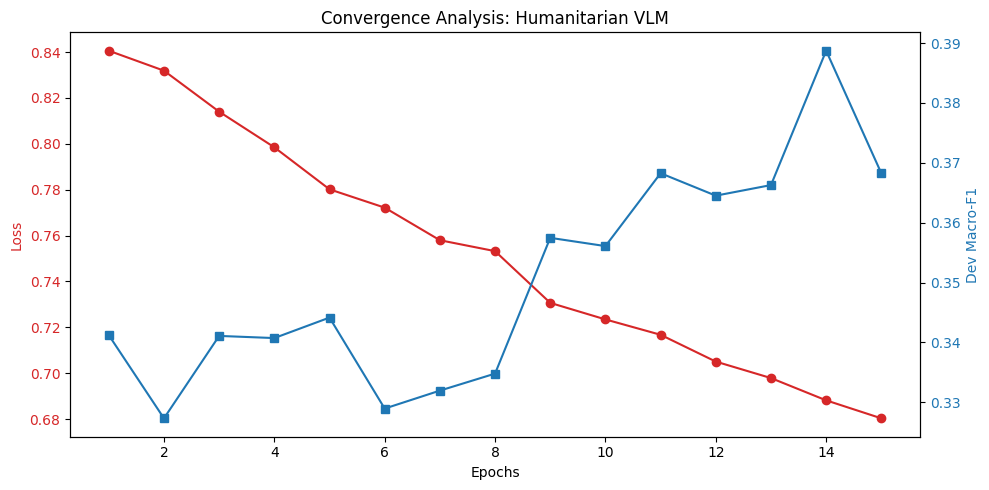


🏁 Evaluating on Unseen Test Set...


C:\Users\nabil\AppData\Local\Temp\ipykernel_24084\3362279216.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_humanitarian_model.


🏆 FINAL TEST SET PERFORMANCE


ValueError: Number of classes, 7, does not match size of target_names, 8. Try specifying the labels parameter

In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# --- 1. INITIALIZATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Differential Learning Rates: Backbone vs. Fusion/Head
optimizer = optim.AdamW([
    {'params': model.base_model.clip.parameters(), 'lr': 1e-6, 'weight_decay': 0.05},
    {'params': model.base_model.fusion.parameters(), 'lr': 5e-4},
    {'params': model.base_model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

criterion = FocalLoss(gamma=2.0)
scaler = GradScaler('cuda')
best_val_f1 = 0
patience = 4
counter = 0

# History trackers for Journal Plots
history = {'train_loss': [], 'dev_f1': [], 'epoch': []}

# --- 2. TRAINING & DEV LOOP ---
print(f"📡 Starting Training on {device}...")

for epoch in range(15):
    # --- TRAINING PHASE ---
    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/15 [Train]")
    
    for batch in train_loop:
        if batch is None: continue
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            outputs = model(ids, mask, pix)
            loss = criterion(outputs, lbl)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_train_loss += loss.item()
        train_loop.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['epoch'].append(epoch + 1)

    # --- VALIDATION PHASE (DEV SET) ---
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in tqdm(dev_loader, desc="🔍 Validating (Dev)"):
            if b is None: continue
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy())
            val_labels.extend(b['label'].numpy())
    
    current_val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    history['dev_f1'].append(current_val_f1)
    
    print(f"\n📈 Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.4f} | Dev Macro-F1: {current_val_f1:.4f}")

    # Check for improvement on Dev Set
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_humanitarian_model.pth')
        print("⭐ Best Model Saved based on Dev F1!")
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early stopping triggered after {patience} epochs of no improvement.")
            break

# --- 3. TRAINING HISTORY VISUALIZATION ---
def plot_metrics(history):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history['epoch'], history['train_loss'], color='tab:red', label='Train Loss', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Dev Macro-F1', color='tab:blue')
    ax2.plot(history['epoch'], history['dev_f1'], color='tab:blue', label='Dev F1', marker='s')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    plt.title('Convergence Analysis: Humanitarian VLM')
    fig.tight_layout()
    plt.savefig('humanitarian_training_history.png', dpi=300)
    plt.show()

plot_metrics(history)


In [15]:
# --- 4. FINAL TEST PHASE (FIXED) ---
model.load_state_dict(torch.load('best_humanitarian_model.pth'))
model.eval()

test_preds, test_labels = [], []
# Use the full list of names defined in your dataset mapping
full_label_names = [
    "affected_individuals", "infrastructure_and_utility_damage",
    "injured_or_dead_people", "missing_or_found_people",
    "rescue_volunteering_or_donation_effort", "vehicle_damage",
    "other_relevant_information", "not_humanitarian"
]

with torch.no_grad():
    for b in tqdm(test_loader, desc="🎯 Final Testing"):
        if b is None: continue
        out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
        test_preds.extend(torch.argmax(out, 1).cpu().numpy())
        test_labels.extend(b['label'].numpy())

# Convert to numpy for indexing
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

# FIND UNIQUE CLASSES PRESENT IN TEST DATA
# This prevents the "7 vs 8" mismatch error
present_labels = np.unique(np.concatenate((test_labels, test_preds)))
present_names = [full_label_names[i] for i in present_labels]

print("\n" + "="*50)
print("🏆 FINAL TEST SET PERFORMANCE (RESEARCH REPORT)")
print("="*50)

# Pass the labels explicitly to align with names
print(classification_report(
    test_labels, 
    test_preds, 
    labels=present_labels, 
    target_names=present_names, 
    zero_division=0
))

C:\Users\nabil\AppData\Local\Temp\ipykernel_24084\1536575904.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_humanitarian_model.pt


🏆 FINAL TEST SET PERFORMANCE (RESEARCH REPORT)
                                        precision    recall  f1-score   support

                  affected_individuals       0.60      0.17      0.26        18
     infrastructure_and_utility_damage       0.57      0.76      0.65        51
                injured_or_dead_people       0.40      0.25      0.31         8
rescue_volunteering_or_donation_effort       0.64      0.74      0.68        57
                        vehicle_damage       0.00      0.00      0.00         2
            other_relevant_information       0.61      0.42      0.50        85
                      not_humanitarian       0.73      0.82      0.77       133

                              accuracy                           0.65       354
                             macro avg       0.51      0.45      0.45       354
                          weighted avg       0.64      0.65      0.63       354



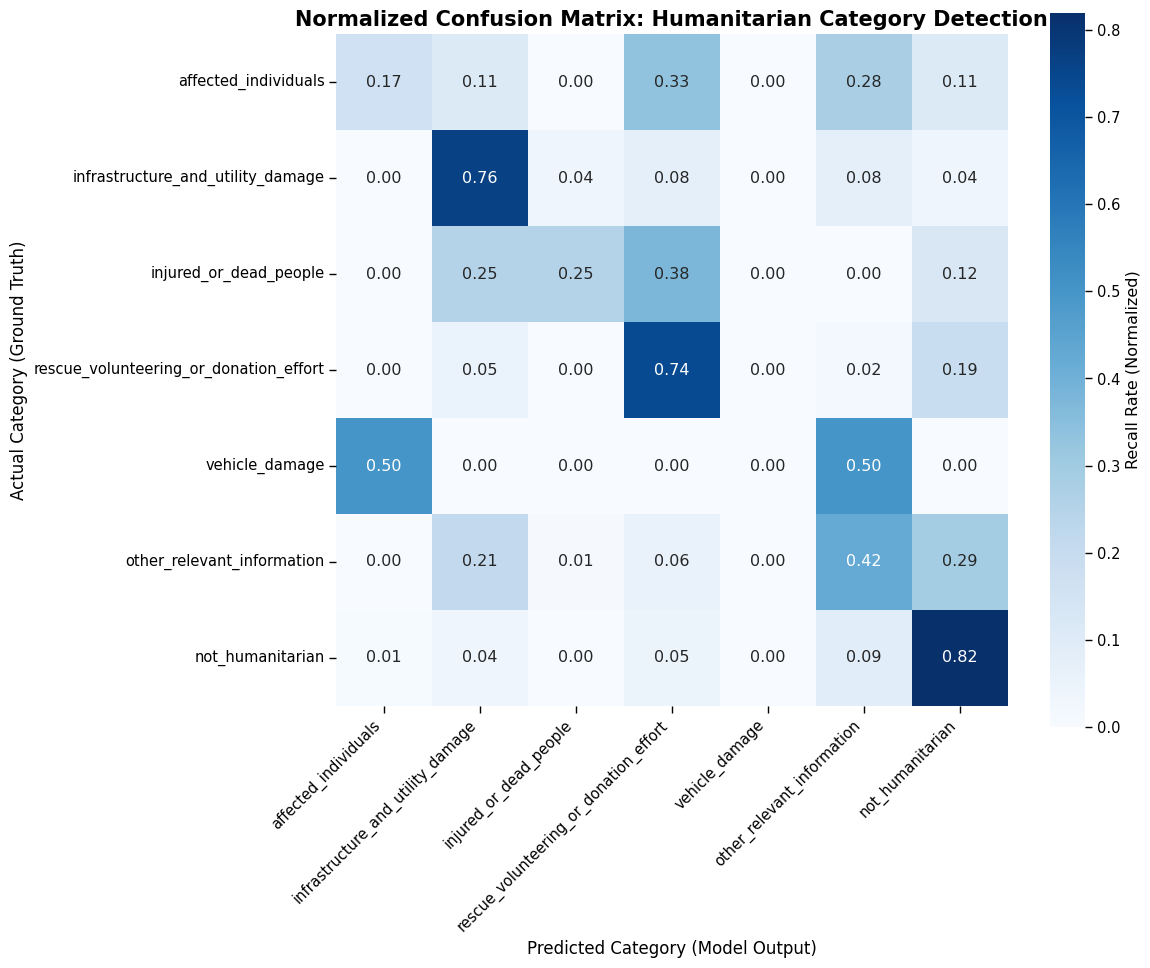

✅ Normalized Confusion Matrix saved as 'humanitarian_confusion_matrix_final.png'


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Define all possible label names (in order)
full_label_names = [
    "affected_individuals", "infrastructure_and_utility_damage",
    "injured_or_dead_people", "missing_or_found_people",
    "rescue_volunteering_or_donation_effort", "vehicle_damage",
    "other_relevant_information", "not_humanitarian"
]

# 2. Identify which classes actually appeared in the test set
# (This fixes the 7 vs 8 mismatch error)
present_labels = np.unique(np.concatenate((test_labels, test_preds)))
present_names = [full_label_names[i] for i in present_labels]

# 3. Calculate the raw confusion matrix
cm = confusion_matrix(test_labels, test_preds, labels=present_labels)

# 4. Normalize the matrix (Percentage of Recall for each class)
# We divide each row by the sum of that row
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm) # Handle division by zero if a class has 0 samples

# 5. Create the Visualization
plt.figure(figsize=(12, 10))
sns.set_context("paper", font_scale=1.2) # Professional journal formatting

sns.heatmap(
    cm_norm, 
    annot=True,          # Show the percentage values
    fmt='.2f',           # 2 decimal places
    cmap='Blues',        # Professional blue gradient
    xticklabels=present_names, 
    yticklabels=present_names,
    square=True,
    cbar_kws={'label': 'Recall Rate (Normalized)'}
)

plt.title('Normalized Confusion Matrix: Humanitarian Category Detection', fontsize=15, fontweight='bold')
plt.ylabel('Actual Category (Ground Truth)', fontsize=12)
plt.xlabel('Predicted Category (Model Output)', fontsize=12)

# Rotate labels for better readability in a paper
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Save with high resolution for publication
plt.savefig('humanitarian_confusion_matrix_final.png', dpi=300)
plt.show()

print("✅ Normalized Confusion Matrix saved as 'humanitarian_confusion_matrix_final.png'")